# 3. 데이터 전처리

2장에서는 데이터 탐색을 해보았는데, 이번 장에서는 데이터 전처리를 해보겠습니다.

인기 있는 데이터셋의 경우 수천 수만장의 이미지를 가지고 있습니다. 하지만 모든 데이터셋이 그렇진 못합니다.  그러면 제한된 데이터셋을 학습 시키기 위해서는 어떻게 해결 해야 할까요?

우리는 데이터셋이 부족하다고 새로운 이미지를 찾을 필요가 없습니다. 왜냐하면 데이터 Augmentation을 이용하여 다양한 상태의 이미지를 얻을 수 있기 때문입니다. 

![](https://drive.google.com/uc?id=1ammM-EnG9aCvMsLvpm-P-6UvOz56M9P3)
- 그림 3.1 같아 보이지만 다른 테니스 공 (출처:https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)

그림 3.1은 사람이 보기엔 다 똑같은 테니스 공입니다. 하지만 신경망은 3개의 테니스 공을 다 다르게 봅니다. 이와 같은 원리로 우리는 하나의 사진을 변조 시켜 여러 개의 데이터를 추출해낼 수 있습니다.

3.1절에서는 이미지 Augmentation이 사용되는 torchvision.transforms와 Albumentations 모듈을 알아보겠습니다. torchvision.transforms는 파이토치에서 공식적으로 제공하는 모듈이며 Albumentations는 OpenCV와 같은 오픈 소스 컴퓨터 비젼 라이브러리를 최적화 하였기에 다른 image argumentation 라이브러리보다 더 빠른 처리 속도 및 기타 기능을 제공하는 모듈입니다. 

언급된 두 모듈 모두 이미지 분류용 모델 구축을 위한 augmentation에는 사용 가능합니다. 하지만 객체 탐지용 모델 구축을 위한 이미지 augmentation 기능은 Albumentations에서만 제공 됩니다. 객체 탐지용 이미지 Augmentation은 이미지 뿐만 아니라 바운딩 박스 까지 변형을 주어야 하는데, torchvision.transforms에는 해당 기능을 제공하지 않습니다. 

그러므로 3.2절에서는 Albumentations를 활용해 바운딩 박스 augmentation을 실습해보겠습니다. 마지막으로 3.3절에서는 데이터를 훈련용 데이터와 시험용 데이터로 분리하는 작업을 실시하겠습니다.



## 3.1 Augmentation 실습

Augmentation 실습을 위해 2.1절에 나온 코드를 활용하여 데이터를 불러오겠습니다.

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-DataLoader
!python Tutorial-Book-DataLoader/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-DataLoader'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
Face Mask Detection.zip is done!


최신 버전의 albumentations 모듈을 사용하기 위해 업그레이드를 진행합니다.

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 952kB 13.6MB/s 
     |████████████████████████████████| 36.7MB 128kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


augmentation 결과물을 시각화하기 위해 2.3절에 나온 바운딩 박스 도식화 코드를 가지고 오겠습니다.

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img_path, annotation):
    
    img = img_path.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')

        ax.add_patch(rect)

    plt.show()

### 3.1.1 Torchvision Transforms

torchvision.transforms을 실습하기 위해 `TorchvisionDataset` 클래스를 먼저 정의하겠습니다. `TorchvisionDataset` 클래스는`__getitem__` 메소드를 통해 image를 불러온 다음 데이터 augmentation을 진행합니다. transform 파라미터에 저장돼 있는 augmenation 규칙에 의해 augmentation이 이뤄집니다. 시간 측정을 위해 `time`함수를 사용하여 시각 측정 후, 최종적으로 image, label, total_time을 반환해줍니다.

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
from PIL import Image
import random

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

trainsforms에서 제공하는 함수를 활용해 이미지 augmentation 실습을 진행해보겠습니다. 이미지를 (300, 300) 크기로 만든 후, 이미지를 224 크기로 자르도록 하겠습니다. 그리고 나서 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 무작위로 바꿔보겠습니다. 마지막으로 좌우반전을 적용시킨 후 ToTensor로 변환하는 작업을 진행해보겠습니다.

In [ ]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)), 
    transforms.RandomCrop(224),
    transforms.ColorJitter(0.2,0.2,0.2,0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)

transforms에서 제공하는 `Resize` 함수를 통해 이미지 크기를 조정할 수 있으며, `RandomCrop` 함수를 통해 크기를 자를 수 있습니다. `ColorJitter` 함수는 밝기, 대비, 채도, 색조 등을 임의로 바꾸는 기능을 하며 `RandomHorizontalFlip`은 정의한 p의 확률로 좌우반전을 실시합니다. 아래 코드를 실행해 변경 전과 변경 후의 이미지를 비교해보겠습니다.

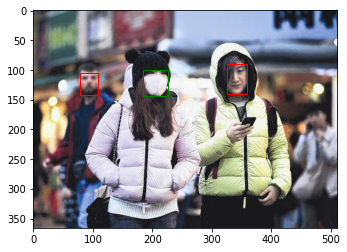

In [ ]:
# 변경 전
torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/'
)
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(torch.as_tensor(np.array(img)).permute(2,0,1), annot)

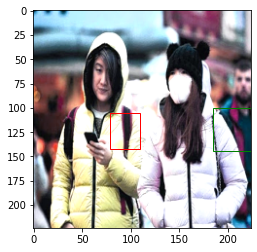

In [ ]:
# 변경 후
img, annot, transform_time = torchvision_dataset[0]
plot_image_from_output(img, annot)

변경 전에 비해 변경 후 이미지는 앞서 언급한 변화들이 적용된 것을 볼 수 있습니다. 또한 이미지 자체적인 변화는 이뤄졌지만 바운딩 박스는 변화된 이미지에서 위치가 어긋 난 것을 확인할 수 있습니다. torchvision.transform에서 제공하는 augmentation은 이미지 값에 대한 augmentation만 진행이 되며, 그에 따라 바운딩 박스는 같이 변환 되지 않는 것을 알 수 있습니다. 이미지 분류 문제에서는 이미지가 변해도 라벨 값이 고정이지만, 객체 검출 문제에서는 이미지가 변함에 따라 라벨 값 또한 함께 변해야 합니다. 3.2 절에서 이러한 문제를 해결하는 방법에 대해 알아보겠습니다. 우선 3.1 절에서는 torchvision과 albumentations 모듈 비교를 계속 진행하도록 하겠습니다. torchvision_dataset에서 이미지 변환에 소요된 시간을 계산하고 그것을 100번 반복한 시간을 아래 코드를 활용해 측정하겠습니다.

In [ ]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 11.102776527404785 ms


이미지 변환을 100번 수행하는데 약 11.2 ms가 소요된 것을 확인할 수 있습니다.

### 3.1.2 Albumentation

앞서 3.1.1절에서는 torchvision.transforms의 변환 속도를 측정해보았습니다. 이번 절에서는 또 다른 augmentation 모듈인 Albumentations를 확인해보겠습니다. torchvision과 마찬가지로 먼저 데이터셋 클래스를 정의하겠습니다. `AlbumentationDataset`은 `TorchVisionDataset`과 비슷한 구조를 가지고 있습니다.
cv2 모듈을 사용하여 이미지를 읽고 RGB로 바꿔줍니다. 그리고 이미지 변환을 실시한 후 결과값을 반환합니다 

In [ ]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

torchvision.transform과의 속도 비교를 위해 같은 기능인 `Resize`, `RandomCrop`, `ColorJitter`, `HorizontalFlip`을 사용해보겠습니다. 그리고 나서 변경 전과 변경 후 이미지를 비교해보겠습니다.

In [ ]:
# Same transform with torchvision_transform
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

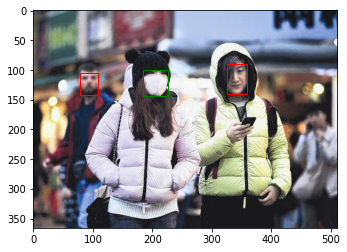

In [ ]:
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(torch.as_tensor(np.array(img)).permute(2,0,1), annot)

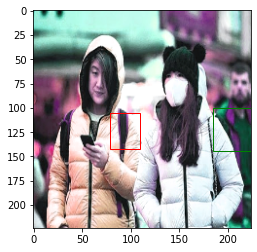

In [ ]:
# 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

torchvision과 마찬가지로 이미지 변환이 이루어 졌지만, 바운딩 박스는 변하지 않은 것을 알 수 있습니다. 속도 측정을 위해 transform을 100번 적용 시킨 뒤 시간을 측정하겠습니다


In [ ]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 2.4160075187683105 ms


이미지 변환을 100번 수행하는데 약 2.4 ms가 소요된 것을 확인할 수 있습니다. torchvision.transforms와 비교했을 때 약 4배 정도 빠른 것을 알 수 있습니다. 

### 3.1.3 확률 기반 Augmentation 조합


Albmentations는 torchvision.transforms 보다 속도가 빠를 뿐만 아니라 새로운 기능 또한 제공합니다. 이번 절에서는 Albumentations에서 제공하는 `OneOf` 함수에 대해 알아보겠습니다. 이 함수는 list 안에 있는 augmentation 기능 들을 주어진 확률 값에 기반하여 가져옵니다. list 값 자체의 확률 값과 더불어 해당 함수의 확률 값을 함께 고려하여 실행 여부를 결정합니다. 아래의 `OneOf` 함수는 각각 선택될 확률이 1 입니다. 각각의 함수 내부에 있는 3개의 albumentations 기능들 또한 각각 확률 값이 1로 부여 됬으므로, 실질적으로 1/3의 확률로 3개의 기능 중 하나가 선택되어 실행 된다는 것을 알 수 있습니다. 이렇게 확률 값을 조정하여 다양한 augmentation이 가능합니다. 

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

아래는 albumentations_transform_oneof를 이미지에 10번 적용한 결과입니다. 

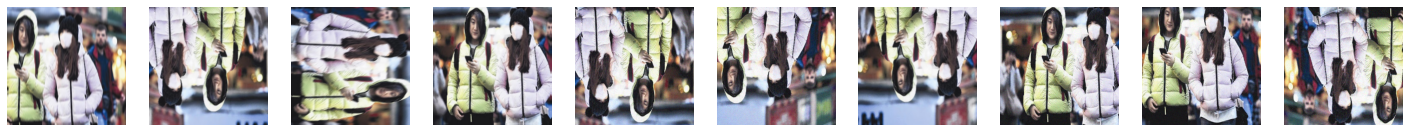

In [ ]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

## 3.2 바운딩 박스 Augmentation

객체 탐지 모델 구축에 사용되는 이미지에 대한 augmentation 진행 시, 이미지 변환 뿐만 아니라 그에 따른 바운딩 박스 변환 또한 함께 진행해주어야 합니다. 3.1절에서 보았듯이 바운딩 박스를 함께 변환 시켜 주지 않으면 바운딩 박스가 엉뚱한 곳을 탐지하고 있기 때문에 모델 학습이 제대로 이뤄지지 않을 것입니다. Albumentations에서 제공하는 Compose 함수에 있는 bbox_params 파라미터를 활용하면 바운딩 박스 augmentation이 가능합니다.

우선 아래 코드를 활용하여 새로운 데이터셋 클래스를 생성하겠습니다. 3.1.2 절에서 확인한 `AlbumentationsDataset` 클래스의 transform 부분을 수정하였습니다. 이미지 뿐만 아니라 바운딩 박스도 transform이 진행되기 때문에 필요한 입력값, 출력값 수정을 진행해주었습니다. 

In [ ]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            total_time = (time.time() - start_t)
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target, total_time

다음으로는 `albumentations.Compose` 함수를 활용해 변환을 정의해보겠습니다. 가장 먼저 좌우반전을 실시할 것이며, 그 이후에 -90도에서 90도 사이의 회전을 진행하겠습니다. 바운딩 박스도 함께 변환을 진행해주기 위해 bbox_params 파라미터에 `albumentations.BboxParams` 객체를 입력해줍니다. Face Mask Detection 데이터셋은 바운딩 박스 표기법이 `xmin`, `ymin`, `xmax`, `ymax`으로 돼있고, 이것은 pascal_voc 표기법과 같습니다. 그러므로 format 파라미터에 pascal_voc을 입력합니다. 또한 `transform` 진행 시 객체 별 클래스 값은 `labels` 파라미터에 저장해두기 위해 `label_field`에 `labels`를 입력합니다.

In [ ]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

이제 `BboxAugmentationDataset` 클래스를 활성화 하여 augmentation 결과물을 확인해보겠습니다.

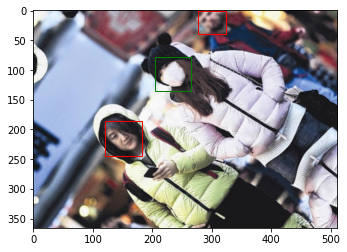

In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot, transform_time = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

위 코드를 실행할 때 마다 이미지가 변환되어서 출력되는 것을 확인할 수 있습니다. 그와 더불어 바운딩 박스 또한 알맞게 변환되어 변환된 이미지에 있는 마스크 착용 얼굴들을 정확히 탐지하는 것을 볼 수 있습니다. 이렇게 이미지와 바운딩 박스를 함께 변환한 데이터를 활용해 4장과 5장에서 모델을 구축해보겠습니다. 

## 3.3 데이터 분리 

인공지능 모델을 구축하기 위해선 학습용 데이터와 시험 데이터가 필요합니다. 학습용 데이터는 모델 훈련 시 사용하며 시험 데이터는 모델 평가 시 사용합니다. 시험 데이터는 학습용 데이터와 중복 되지 않아야 합니다. 3.1절에서 불러온 데이터를 학습 데이터와 시험 데이터로 나누어 보겠습니다. 

우선 전체 데이터의 개수를 아래 코드를 통해 확인해보겠습니다. 

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


총 853개의 이미지가 존재하는 것을 볼 수 있습니다. 일반적으로 학습 데이터와 시험 데이터의 비율은 7:3 으로 가져갑니다. 이번 데이터는 전체 데이터셋 개수가 적으므로 8:2 비율을 가져가보도록 하겠습니다. 853개의 데이터 중 170개를 시험 데이터로 사용하기 위해 해당 데이터를 별도의 폴더로 옮겨 주도록 하겠습니다. 우선 리눅스 명령어 mkdir를 활용하여 시험 데이터를 담을 폴더를 생성합니다. 

In [ ]:
!mkdir test_images
!mkdir test_annotations

위 코드를 실행 하면 test_images 폴더와 test_annotations 폴더가 생성된 것을 확인할 수 있습니다. 이제 images 폴더와 annotations 폴더에 있는 파일 각각 170개씩을 새로 생성한 폴더로 옮기겠습니다. random 모듈에 있는 sample 함수를 활용해 무작위로 숫자를 추출한 후 인덱스 값으로 활용하겠습니다. 

In [ ]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [ ]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)



위의 코드 처럼 shutil 패키지를 활용해 170개의 이미지와 170개의 좌표 파일들을 각각 test_images폴더와 test_annotations 폴더로 옮길 수 있습니다. 각 폴더별 파일 개수를 확인하면 아래와 같이 나올 것입니다. 

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


지금까지 Albumentations 모듈을 활용해 객체 검출 모델 구축에 사용되는 이미지를 부풀리는 방법을 알아보았고, 보유한 데이터를 학습용 데이터와 시험용 데이터로 분리하는 방법을 알아보았습니다. 4장에서는 One-Stage 모델인 RetinaNet을 학습시켜 마스크 착용 탐지 모델을 구축해보겠습니다. 